In [1]:
# Main notebook task
# Read RTC and create a 3 by 3 data collection. 
# Store into a csv

In [2]:
import os
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip
import pandas as pd
import numpy as np
import rioxarray
import xarray as xr
from pyproj import Transformer
import ast
import matplotlib.pyplot as plt

### 1. Get table with the processed RTC's information.
This table will be use to ingest the data. 

In [3]:
# Read RTC summary table
df_rtc = pd.read_json('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/marshak/4_rtc_organization/rtc_s1_table.json.zip')
print("Total of RTC's:", len(df_rtc))
df_rtc.head()

Total of RTC's: 237853


,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


### 2. Get the Burst summary table.
It will be used to match to CalVal site table and extract relevant information 

In [4]:
# We need to group them by RTC ID so that a time series is generated
# Read the Burst sumary table 
# Read available bursts
df_burst_summary = read_geojson_gzip('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/marshak/4_rtc_organization/burst_extent_subset.geojson.zip')
df_burst_summary.head()

,geometry,jpl_burst_id,orbit_pass,count,is_val_burst,track_number
0,"POLYGON ((-97.90103 16.86358, -97.06559 17.014...",T005-008688-IW2,ASCENDING,66,False,5
1,"POLYGON ((-97.09889 17.06678, -96.35903 17.196...",T005-008688-IW3,ASCENDING,66,False,5
2,"POLYGON ((-98.69437 16.82087, -97.89903 16.966...",T005-008689-IW1,ASCENDING,66,False,5
3,"POLYGON ((-97.93485 17.03023, -97.09864 17.180...",T005-008689-IW2,ASCENDING,66,False,5
4,"POLYGON ((-97.13196 17.23328, -96.39139 17.362...",T005-008689-IW3,ASCENDING,66,False,5


### 3. Read CalVal sites to associate them with the bursts.
A table with site id and burst id is formed. 

In [5]:
df_val_sites = gpd.read_file('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/dist_hls_val_sites.geojson')
df_val_sites_subset = gpd.sjoin(df_val_sites, df_burst_summary[['jpl_burst_id', 'geometry']], predicate='intersects', how='inner').drop(columns=['index_right']).reset_index(drop=True)
df_val_sites_subset.head()

,site_id,change_label,change_time,last_observation_time,geometry,jpl_burst_id
0,4,VLmaj,2021-11-07,2021-11-02,POINT (19.33289 4.57490),T036-076228-IW3
1,13,VLmaj,2021-10-03,NaT,POINT (48.77698 31.75490),T108-230715-IW2
2,13,VLmaj,2021-10-03,NaT,POINT (48.77698 31.75490),T101-214979-IW1
3,22,VLmin,2021-12-19,2021-12-12,POINT (36.61178 35.52891),T014-028130-IW2
4,22,VLmin,2021-12-19,2021-12-12,POINT (36.61178 35.52891),T021-043823-IW2


### 4. Define functions to load RTC and export to table

In [6]:
# Get selected RTC EPSG to project validation coords 
def get_epsg(file_path):
    with rasterio.open(file_path) as dataset:
        crs = dataset.crs
        if crs.is_epsg_code:
            return crs.to_epsg()
        else:
            return None
        
# Load RTC 
def load_rtc(df_rtc_ts, val_site_df):
    polarizations = ['vv', 'vh']
    da_stack = []

    # Define the longitude and latitude of the pixel to load
    lon, lat = val_site_df['geometry'].values[0].x, val_site_df['geometry'].values[0].y
    print(f'CalVal site lon:{lon}, lat:{lat}')

    # Initialize a transformer to convert lon/lat to the image's coordinate system
    file_path = df_rtc_ts.iloc[0]['rtc_s1_vv_url']
    epsg_code = get_epsg(file_path)
    transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_code}", always_xy=True)

    # Transform the lon/lat to the target coordinate system
    coord_x, coord_y = transformer.transform(lon, lat)
    print('Loading data for coords x,y:', coord_x, coord_y)

    for t, row in df_rtc_ts.iterrows():
        rtc_id = row['rtc_s1_id']
        time = pd.to_datetime(row['acq_datetime'])
        polarization_stack = []

        for polarization in polarizations:
            file_path = row[f"rtc_s1_{polarization}_url"]

            # Open the file and query the specific pixel value
            with rioxarray.open_rasterio(file_path) as da:
                # Find the nearest pixel indices for the given coordinates
                pixel_x = da.indexes['x'].get_indexer([coord_x], method="nearest")[0]
                pixel_y = da.indexes['y'].get_indexer([coord_y], method="nearest")[0]
                
                # Extract a 3x3 window centered at the nearest pixel
                da_window = da.isel(x=slice(pixel_x - 1, pixel_x + 2), y=slice(pixel_y - 1, pixel_y + 2))
                da_window = da_window.expand_dims(time=pd.Index([time], name='time'))
                polarization_stack.append(da_window)

        da_polarized = xr.concat(polarization_stack, dim=pd.Index(polarizations, name='polarization'))
        da_stack.append(da_polarized)

    ds = xr.concat(da_stack, dim='time')

    return ds, coord_x, coord_y

# create csv table
def summary_table(ds, coord_x, coord_y, df_rtc_ts, val_site_df): 
    data = []
    for t, row in df_rtc_ts.iterrows():
        time = pd.to_datetime(row['acq_datetime'])
        record = {'datetime': time}
        vv_window = ds.sel(time=time, polarization='vv').values
        vh_window = ds.sel(time=time, polarization='vh').values
        record['vv'] = vv_window.flatten().tolist()
        record['vh'] = vh_window.flatten().tolist()
        # Calculate the vv/vh ratio and handle division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_window = np.where(vh_window != 0, vv_window / vh_window, np.nan)
        record['vv/vh'] = ratio_window.flatten().tolist()
        data.append(record)

    df = pd.DataFrame(data)
    df['burst_id'] = val_site_df['jpl_burst_id'].values[0]
    df['site_id'] = val_site_df['site_id'].values[0]
    df['site_lon'] = val_site_df['geometry'].values[0].x 
    df['site_lat'] = val_site_df['geometry'].values[0].x
    df['site_x'] = coord_x 
    df['site_y'] = coord_y
    df['orbit_pass_direction'] = ds.attrs.get("ORBIT_PASS_DIRECTION")

    # Reorder columns
    desired_order = ['datetime', 'burst_id', 'orbit_pass_direction','site_id', 'site_lon', 'site_lat', 'site_x', 'site_y', 'vv', 'vh', 'vv/vh']
    df = df[desired_order]

    # Store table
    out_csv = f'/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/tables/rtc_summary_burst_{val_site_df['jpl_burst_id'].values[0]}_site{val_site_df['site_id'].values[0]}.csv'
    df.to_csv(out_csv)


### 5. Run script to load and export RTC tables

In [7]:
# # Run script for all Bursts
# # Driver
# for BURST_ID in df_burst_summary['jpl_burst_id'].unique():
#     print(f"Running BurstID {BURST_ID}")
#     val_site_df = df_val_sites_subset[df_val_sites_subset['jpl_burst_id'] == BURST_ID]
#     if val_site_df.empty:
#         print(f"No matches for Burst:{BURST_ID}")
#         continue
#     # Check if the file exists
#     out_csv = f'/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/tables/rtc_summary_burst_{val_site_df['jpl_burst_id'].values[0]}_site{val_site_df['site_id'].values[0]}.csv'
#     if os.path.exists(out_csv):
#         print(f"The file '{out_csv}' exists. Skipping process.")
#         continue 
#     else:
#         print(f"Loading table '{out_csv}'. Proceeding with process.")
#         print(f"Calval site matched:{val_site_df['site_id'].values[0]}")
#         df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
#         ds, cx, cy = load_rtc(df_rtc_ts, val_site_df)
#         summary_table(ds, cx, cy, df_rtc_ts, val_site_df) 

In [8]:
# Run script for a single defined burst
BURST_ID = 'T101-214979-IW1'

print(f"Running BurstID {BURST_ID}")
val_site_df = df_val_sites_subset[df_val_sites_subset['jpl_burst_id'] == BURST_ID]
if val_site_df.empty:
    print(f"No matches for Burst:{BURST_ID}")
# Check if the file exists
out_csv = f'/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/tables/rtc_summary_burst_{val_site_df['jpl_burst_id'].values[0]}_site{val_site_df['site_id'].values[0]}.csv'
if os.path.exists(out_csv):
    print(f"The file '{out_csv}' exists. Skipping process.") 
else:
    print(f"Loading table '{out_csv}'. Proceeding with process.")
    print(f"Calval site matched:{val_site_df['site_id'].values[0]}")
    df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
    ds, cx, cy = load_rtc(df_rtc_ts, val_site_df)
    summary_table(ds, cx, cy, df_rtc_ts, val_site_df) 

Running BurstID T101-214979-IW1
The file '/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis/tables/rtc_summary_burst_T101-214979-IW1_site13.csv' exists. Skipping process.


### 6. Load CSV as a geodataframe and visualize. 

In [9]:
burst_df = pd.read_csv(out_csv)
burst_df

,Unnamed: 0,datetime,burst_id,orbit_pass_direction,site_id,site_lon,site_lat,site_x,site_y,vv,vh,vv/vh
0,0,2020-10-04 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.07013288140296936, 0.08039900660514832, 0.0...","[0.003235119627788663, 0.0016010524705052376, ...","[21.678606033325195, 50.216346740722656, 10.40..."
1,1,2020-10-10 14:42:45,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.08997806906700134, 0.12624962627887726, 0.0...","[0.0026379628106951714, 0.003773188218474388, ...","[34.10892105102539, 33.45966720581055, 11.7901..."
2,2,2020-10-16 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.05894654989242554, 0.09100878238677979, 0.0...","[0.0041472455486655235, 0.00682450458407402, 0...","[14.213421821594238, 13.335588455200195, 7.192..."
3,3,2020-10-22 14:42:44,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.06748474389314651, 0.08431867510080338, 0.0...","[0.009487247094511986, 0.011938171461224556, 0...","[7.113205909729004, 7.0629472732543945, 5.4472..."
4,4,2020-10-28 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.06509364396333694, 0.06484794616699219, 0.0...","[0.0038146667648106813, 0.0018035272369161248,...","[17.064044952392578, 35.9561767578125, 13.5041..."
...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,2022-10-06 14:43:35,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.16522927582263947, 0.23472240567207336, 0.2...","[0.06703083962202072, 0.039849113672971725, 0....","[2.4649739265441895, 5.890279293060303, 9.1790..."
97,97,2022-10-18 14:43:36,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.12551966309547424, 0.17847813665866852, 0.2...","[0.019992385059595108, 0.041203856468200684, 0...","[6.278373718261719, 4.331588268280029, 5.70240..."
98,98,2022-10-30 14:43:36,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.2967866063117981, 0.2335222214460373, 0.228...","[0.02498103305697441, 0.029504435136914253, 0....","[11.880477905273438, 7.9148173332214355, 3.255..."
99,99,2022-11-11 14:43:35,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.14702044427394867, 0.176509290933609, 0.342...","[0.041409317404031754, 0.03738131374120712, 0....","[3.550419330596924, 4.721858978271484, 5.81032..."


In [10]:
# Function to convert string
def convert_to_list(v):
    if isinstance(v, str):
        return ast.literal_eval(v)
    return v

In [11]:
# convert lists
burst_df['vv'] = burst_df['vv'].apply(convert_to_list)
burst_df['vh'] = burst_df['vh'].apply(convert_to_list)
burst_df['vv/vh'] = burst_df['vv/vh'].apply(convert_to_list)

# Calculate the average of each list in the column vv and add ne average column
burst_df['vv_avg'] = burst_df['vv'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
burst_df['vh_avg'] = burst_df['vh'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
burst_df['vv/vh_avg'] = burst_df['vv/vh'].apply(lambda x: sum(x) / len(x) if isinstance(x, list) else x)
burst_df


,Unnamed: 0,datetime,burst_id,orbit_pass_direction,site_id,site_lon,site_lat,site_x,site_y,vv,vh,vv/vh,vv_avg,vh_avg,vv/vh_avg
0,0,2020-10-04 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.07013288140296936, 0.08039900660514832, 0.0...","[0.003235119627788663, 0.0016010524705052376, ...","[21.678606033325195, 50.216346740722656, 10.40...",0.076980,0.005373,19.409589
1,1,2020-10-10 14:42:45,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.08997806906700134, 0.12624962627887726, 0.0...","[0.0026379628106951714, 0.003773188218474388, ...","[34.10892105102539, 33.45966720581055, 11.7901...",0.092462,0.003764,26.105509
2,2,2020-10-16 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.05894654989242554, 0.09100878238677979, 0.0...","[0.0041472455486655235, 0.00682450458407402, 0...","[14.213421821594238, 13.335588455200195, 7.192...",0.078042,0.006114,15.519343
3,3,2020-10-22 14:42:44,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.06748474389314651, 0.08431867510080338, 0.0...","[0.009487247094511986, 0.011938171461224556, 0...","[7.113205909729004, 7.0629472732543945, 5.4472...",0.074069,0.007057,13.035152
4,4,2020-10-28 14:43:24,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.06509364396333694, 0.06484794616699219, 0.0...","[0.0038146667648106813, 0.0018035272369161248,...","[17.064044952392578, 35.9561767578125, 13.5041...",0.071064,0.004485,18.794380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,2022-10-06 14:43:35,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.16522927582263947, 0.23472240567207336, 0.2...","[0.06703083962202072, 0.039849113672971725, 0....","[2.4649739265441895, 5.890279293060303, 9.1790...",0.211327,0.063826,3.989625
97,97,2022-10-18 14:43:36,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.12551966309547424, 0.17847813665866852, 0.2...","[0.019992385059595108, 0.041203856468200684, 0...","[6.278373718261719, 4.331588268280029, 5.70240...",0.221846,0.044987,5.080995
98,98,2022-10-30 14:43:36,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.2967866063117981, 0.2335222214460373, 0.228...","[0.02498103305697441, 0.029504435136914253, 0....","[11.880477905273438, 7.9148173332214355, 3.255...",0.300603,0.038158,9.383677
99,99,2022-11-11 14:43:35,T101-214979-IW1,ascending,13,48.776976,48.776976,289443.129892,3.515419e+06,"[0.14702044427394867, 0.176509290933609, 0.342...","[0.041409317404031754, 0.03738131374120712, 0....","[3.550419330596924, 4.721858978271484, 5.81032...",0.211810,0.054909,4.104836


/var/folders/02/_hsgd2_d5pb_t5xm0m8xh5v00000gr/T/ipykernel_6237/2970700324.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(burst_df['datetime'], rotation=90)


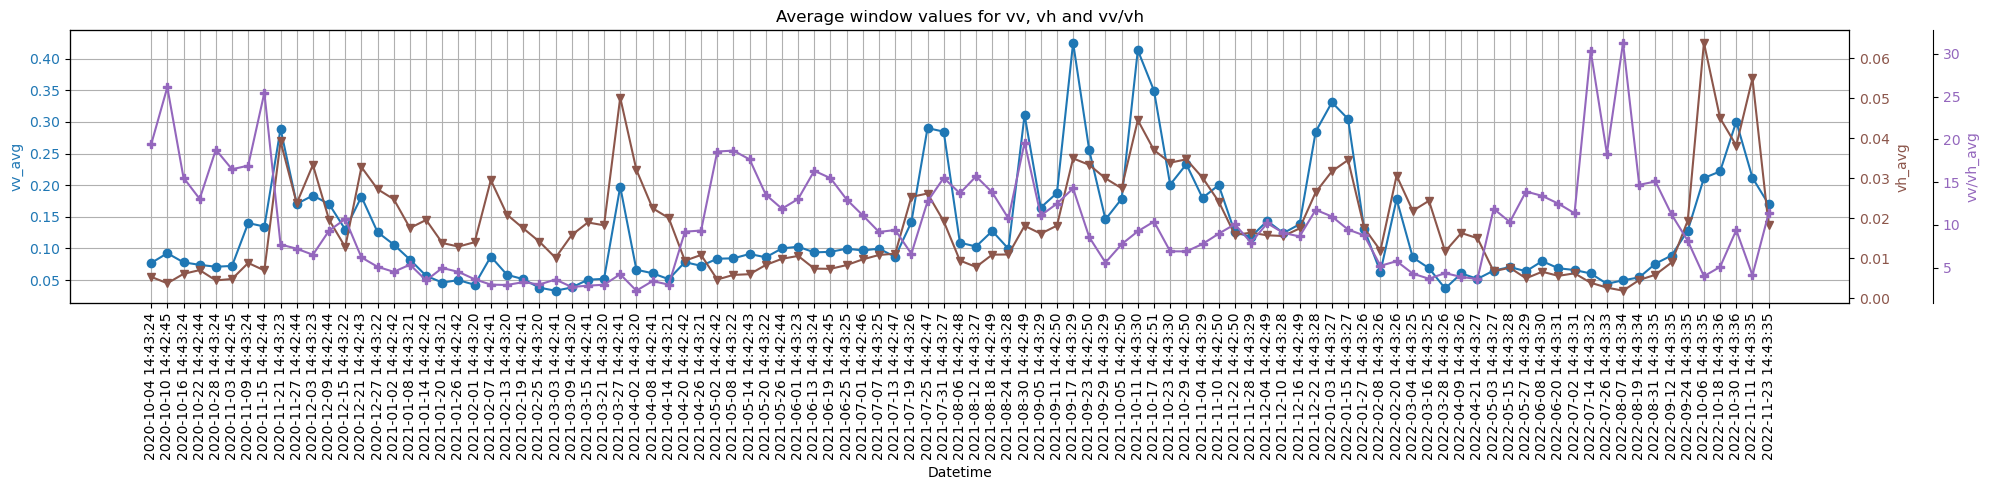

In [12]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(burst_df['datetime'], burst_df['vv_avg'], marker='o', color='tab:blue', label='vv_avg')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('vv_avg', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(burst_df['datetime'], burst_df['vh_avg'], marker='v', color='tab:brown', label='vh_avg')
ax2.set_ylabel('vh_avg', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='tab:brown')
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  
ax3.plot(burst_df['datetime'], burst_df['vv/vh_avg'], marker='P', color='tab:purple', label='vv/vh_avg')
ax3.set_ylabel('vv/vh_avg', color='tab:purple')
ax3.tick_params(axis='y', labelcolor='tab:purple')
plt.title('Average window values for vv, vh and vv/vh')
ax1.set_xticklabels(burst_df['datetime'], rotation=90)

ax1.grid(True)
fig.tight_layout()

plt.show()
